In [3]:
import sys
sys.path.append('../')

In [4]:
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import os
import glob
from tools import SiteAnalyzer
import pandas as pd
import numpy as np
import ase.io
from fairchem.demo.ocpapi import AdsorbateBindingSites

/home/hoon/anaconda3/envs/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
system_name = "*N*NH_Mo3Pd_mp-1186014_(1,1,1)_0.167"
#"*N*NH_Mo3Pd_mp-1186014_(1,1,1)_0.167"
#"*N*NH_CuPd3_mp-1184119_(1,1,1)_0.063"
system_name2 = "*N*NH_Mo3Pd_mp-1186014_(1, 1, 1)"

llm_heur_path = f"/home/hoon/llm-agent/results/llm_heur/{system_name}"
llm_full_path = f"/home/hoon/llm-agent/results/llm_full/{system_name}"
ocpdemo_path = f"/home/hoon/llm-agent/results/ocpdemo/{system_name2}"

In [35]:
llm_path = llm_heur_path
result = pd.read_pickle(os.path.join(llm_path, 'result.pkl'))
trajs = glob.glob(os.path.join(llm_path, 'traj/*.traj'))
valid_energies = pd.read_pickle(os.path.join(llm_path, 'valid_energies.pkl'))

In [36]:
with open(os.path.join(ocpdemo_path, 'result.json'), 'r') as f:
    demo_results = AdsorbateBindingSites.from_json(f.read())
demo_valid_energies = pd.read_pickle(os.path.join(ocpdemo_path, 'valid_energies.pkl'))

# Adsorption site visualization

In [22]:
# adsoprtion site
ads_sites = []

for traj in trajs:
    init_image = ase.io.read(traj, ':')[0]
    
    site_analyzer = SiteAnalyzer(init_image)
    site = site_analyzer.get_bound_atom_positions()
    site = np.array(site)
    if len(site) >1:
        # get the mean value
        site = np.mean(site, axis=0)
        
    elif len(site) == 1:
        site = site[0]
    elif len(site) == 0:
        site_analyzer = SiteAnalyzer(init_image, cutoff_multiplier=1.5)
        site = site_analyzer.get_bound_atom_positions()
        site = np.array(site)
        if len(site) >1:
            # get the mean value
            site = np.mean(site, axis=0)
        
        elif len(site) == 1:
            site = site[0]
    ads_sites.append(site)

# slab
atoms = ase.io.read(trajs[0], ':')[0]
# slab atoms have tag of 0 and 1
slab_atoms = atoms[[atom.tag in [0,1] for atom in atoms]]

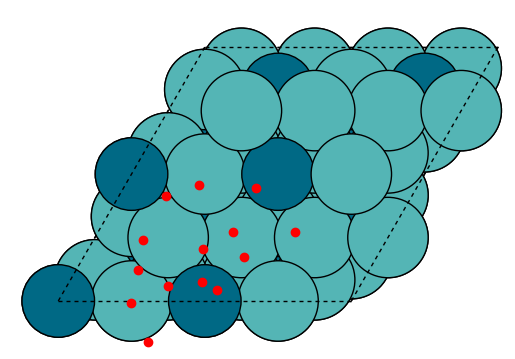

In [23]:
# plotting
fig, ax = plt.subplots()
ax.set_axis_off()
plot_atoms(slab_atoms)
for site in ads_sites:
    plt.scatter(*site[:2], marker='o', color='red')

# plt.xlim(0, 16) 
# plt.ylim(-0.5, 10)
plt.xlim(0, 19)
plt.ylim(-0, 13)
# save the figure
save_path = os.path.join(llm_path, 'ads_sites.png')
plt.savefig(save_path, bbox_inches='tight')

# Visualization of adslabs

In [22]:
# find the min energy and its idx from valid_energies dictionary 
min_energy = 1e10
for idx, energy in valid_energies.items():
    if energy < min_energy:
        min_energy = energy
        min_idx = int(idx.split('_')[1])

In [23]:
# find the matching traj
min_traj_path = os.path.join(llm_path, f'traj/config_{min_idx}.traj')
min_traj = ase.io.read(min_traj_path, ':')
initial_image = min_traj[0]
relaxed_image = min_traj[-1]
# confirm the energy
relaxed_energy = relaxed_image.get_potential_energy()
np.isclose(relaxed_energy, min_energy, 0.01)

True

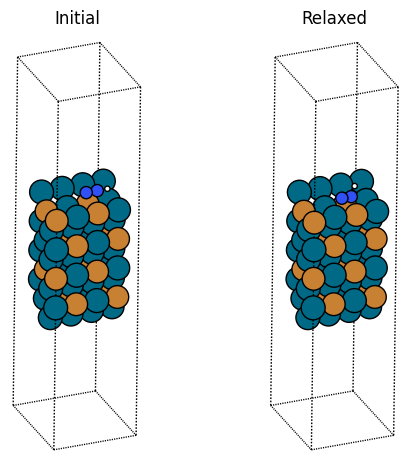

In [24]:
# visualize initial and final structures
fig, ax = plt.subplots(1, 2)
labels = ['Initial', 'Relaxed']
for i in range(2):
    ax[i].axis('off')
    ax[i].set_title(labels[i])
plot_atoms(initial_image, ax[0], radii=0.8, rotation=("-75x, 45y, 10z"))
plot_atoms(relaxed_image, ax[1], radii=0.8, rotation=("-75x, 45y, 10z"))

plt.tight_layout()
save_path = os.path.join(llm_path, 'adslabs.png')
#plt.savefig(save_path, bbox_inches='tight')

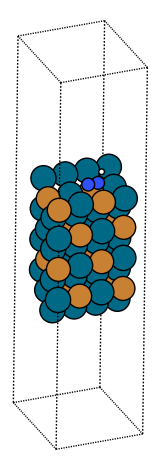

In [25]:
# visualize initial and final structures
fig, ax = plt.subplots()
ax.axis('off')
plot_atoms(relaxed_image, ax, radii=0.8, rotation=("-75x, 45y, 10z"))
plt.tight_layout()
save_path = os.path.join(llm_path, 'relaxed_adslabs.png')
plt.savefig(save_path, bbox_inches='tight')

# Energy curve

In [14]:
# energy trajectory of the min energy traj
llm_energies = []
for image in min_traj:
    energy = image.get_potential_energy()
    llm_energies.append(energy)
    

In [15]:
# find the min energy and its idx from valid_energies dictionary 
demo_min_energy = 1e10
for idx, energy in demo_valid_energies.items():
    slab_idx, config_idx = idx 
    if slab_idx == 0:
        if energy < demo_min_energy:
            demo_min_energy = energy
            demo_min_idx = int(config_idx)

In [16]:
demo_energies = demo_results.slabs[0].configs[config_idx].energy_trajectory

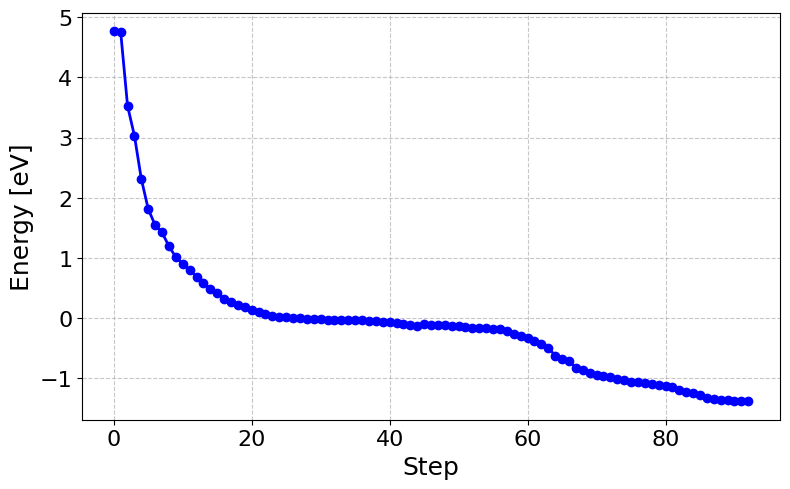

In [18]:
# energy trajectory of the min energy traj


# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the energy trajectory
ax.plot(llm_energies, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
#ax.plot(demo_energies, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)

# Set axis labels
ax.set_xlabel('Step', fontsize=18)
ax.set_ylabel('Energy [eV]', fontsize=18)
# tick size
ax.tick_params(axis='both', which='major', labelsize=16)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set title
# # Display the plot
plt.tight_layout()

# save the figure
save_path = os.path.join(llm_path, 'energy_traj.png')
#plt.savefig(save_path, bbox_inches='tight')

# Energy distribution

In [37]:
valid_energies.values()

dict_values([-1.2294565439224243, -1.1439282894134521, -1.0051368474960327, -0.027028918266296387, -1.0383243560791016, -0.5638716816902161, -1.0150200128555298, -0.25367170572280884, -1.378320336341858, -1.0005522966384888, -1.032849669456482])

In [38]:
demo_valid_energies.values()

dict_values([0.5963156819343567, -0.3593468964099884, -0.22439193725585938, 0.8497255444526672, -0.3228195309638977, 0.19532036781311035, 0.20784533023834229, 0.4171951413154602, 0.653755247592926, 0.028963983058929443, 1.5011682510375977, 0.04264718294143677, 1.246077060699463, 0.5131515860557556, 0.4702600836753845, 0.7077232003211975, -0.05663323402404785, 0.48063474893569946, 0.668042004108429, 0.2370203137397766, -0.13823038339614868, 0.6324450373649597, 0.34213560819625854, 1.2848548889160156, 0.14745807647705078, 0.460604727268219, 0.71843022108078, 0.22315740585327148, -0.6642341017723083, 0.20781028270721436, 0.643899142742157, -0.5218672752380371, 1.2594337463378906, 0.6899766325950623, 0.30966633558273315, 1.767219066619873, 0.34347134828567505, 0.3492352366447449, 0.7703109383583069, -0.6513805985450745, 0.305266797542572, -0.37741339206695557, -0.9548668265342712, 0.9092238545417786, 0.6815125346183777, 0.1570187211036682, 0.5204162001609802, 0.5582669377326965, 0.11140763

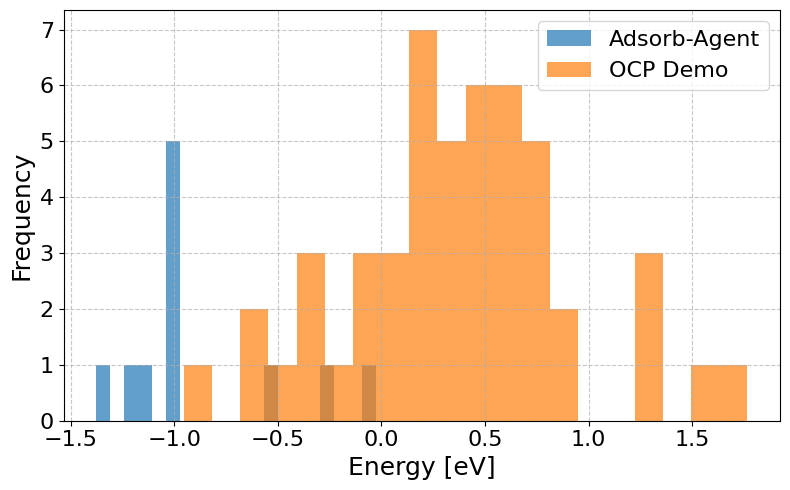

In [39]:
# plot the distribution of the energies

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the valid energy distribution

ax.hist(list(valid_energies.values()), bins=20, alpha=0.7, label='Adsorb-Agent')
ax.hist(list(demo_valid_energies.values()), bins=20, alpha=0.7, label='OCP Demo')

# Set axis labels
ax.set_xlabel('Energy [eV]', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)

# tick size
ax.tick_params(axis='both', which='major', labelsize=16)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set title
# # Display the plot
plt.legend(fontsize=16)
plt.tight_layout()

# save the figure
save_path = os.path.join(llm_path, 'energy_dist.png')